<a href="https://colab.research.google.com/github/Junoflows/Deeplearning_From_Scatch2/blob/main/Chapter_4_word2vec_%EC%86%8D%EB%8F%84_%EA%B0%9C%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4 word2vec 속도 개선

+ 앞선 CBOW 모델의 구현으로는 계산 시간이 너무 오래걸린다.
+ word2vec의 속도를 개선하기 위해 두 가지 개선을 추가한다.
+ Embedding이라는 새로운 계층을 추가한다.
+ 네거티브 샘플링이라는 새로운 손실 함수를 도입힌다.
+ 최종 word2vec이 완성되면 PTB 데이터셋을 가지고 학습을 수행하고 평가한다.

## 4.1 word2vec 개선 1

+ 앞장에서는 CBOW 모델을 구현했다.

<img src='http://drive.google.com/uc?export=view&id=1d6VVmHxyGithdoLAJL5ljDpxvnajhKkH' width = 550/><br>

+ CBOW 모델은 단어 2개를 맥락으로 사용해 하나의 단어(타깃)를 추측한다.
+ 이때 입력 측 가중치와의 행렬 곱으로 은닉층의 계산되고 출력 측 가중치와의 행렬 곱으로 각 단어의 점수를 구한다.
+ 이 점수에 소프트맥스 함수를 적용해 각 단어의 출연 확률을 얻고 정답 레이블과 비교해 손실을 구한다.

+ CBOW 모델은 작은 말뭉치에서는 크게 문제될 것이 없다.
+ 거대한 말뭉치를 다룰 때는 몇 가지 문제가 발생하는데 100만 개 어휘와 100개의 은닉층 뉴런인 CBOW 모델을 살펴보자.

<img src='http://drive.google.com/uc?export=view&id=1vHiiS-uGRE09D6Kmg2flnkp-o92j6cDP' width = 550 /><br>

+ 이 수많은 뉴런 때문에 중간 계산에 많은 시간이 소요되는데 두 가지 계산이 병목이 된다.

> 입력층의 원핫 표현과 가중치 행렬 $W_{in}$ 의 곱 계산

> 은닉층과 가중치 행렬 $W_{out}$ 의 곱 및 Softmax 계층의 계산

+ 첫 번째는 입력층의 원핫 표현과 관련한 문제이다.
+ 단어를 원핫 표현으로 다루기 때문에 어휘가 많아지면 원핫 표현의 벡터 크기가 커지게 된다.
+ 어휘가 100만개이면 벡터 크기도 100만이 되고 가중치 행렬과 곱할 때 계산에 많은 시간이 소요된다.
+ 이는 Embedding 계층 도입으로 해결한다.

+ 두 번째는 은닉층과 가중치 행렬 $W_{out}$ 의 곱에서의 계산량이 많다는 문제점이다.
+ Softmax 계층에서도 어휘가 많아지면 계산량이 증가한다.
+ 이는 네거티브 샘플링이라는 손실 함수를 도입해 해결한다.

### 4.1.1 Embedding 계층

+ word2vec 구현에서 단어를 원핫 표현으로 바꾼 후 MatMul 계층에 입력하고 가중치 행렬을 곱했다.
+ 어휘 수가 100만 개이고 은닉층 뉴런이 100개일 경우 MatMul 계층의 행렬 곱은 다음과 같다.

<img src='http://drive.google.com/uc?export=view&id=1pc0eUOXbJRjJYvcsVY_xhhYOKK9iKq4S' width = 550/><br>

+ 단어의 원핫 표현도 100만 차원이 되고 이런 거대한 벡터와 가중치 행렬을 곱하게 된다.
+ 결과적으로 수행하는 일은 행렬의 특정 행을 추출하는 것으로 불필요한 계산을 많이 하게 된다.

+ 가중치 매개변수로 단어 ID에 해당하는 행을 추출하는 계층 Embedding 계층을 만들어보자.
+ Embedding은 단어 임베딩(분산표현)에서 유래했으며 Embedding 계층에 단어 임베딩을 저장하는 것이다.

### 4.1.2 Embedding 계층 구현

+ 가중치 W가 2차원 넘파이 배열일 때 가중치로부터 특정 행을 추출하려면 원하는 행을 명시하면 된다.
+ 파이썬 코드 예제를 살펴보자.

In [ ]:
import numpy as np
W = np.arange(21).reshape(7,3)
print('W:\n', W)
print('W[2]:',W[2])
print('W[5]:',W[5])

W:
 [[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]
W[2]: [6 7 8]
W[5]: [15 16 17]


+ 가중치 W로부터 여러 행을 한꺼번에 추출하는 일도 원하는 행 번호들을 배열에 명시하면 된다.

In [ ]:
idx = np.array([1,0,3,0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

+ 인수에 배열을 사용하면 여러 행도 한꺼번에 추출할 수 있다.

+ Embedding 계층의 forward()메서드를 구현하자.

In [ ]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

+ 인스턴스 변수 params, grads를 사용하고 idx에는 추출하는 행의 인덱스를 배열로 저장한다.


+ 역전파에 대해 생각해보자.
+ 순전파는 가중치 W의 특정 행을 추출할 뿐으로 가중치의 특정 행 뉴런만 다음 층으로 흘려보낸다.
+ 즉 역전파는 출력층에서 전해진 기울기를 입력층으로 흘려주면 된다.
+ 출력층에서 온 기울기를 가중치 기울기 dW의 특정 행에 설정한다.

<img src='http://drive.google.com/uc?export=view&id=1ditcH00rDK0Darp4U7TWkeXVHohnG2Re' width = 550/><br>

+ 위 내용으로 backward()를 구현해보자.

In [ ]:
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        dW[self.idx] = dout
        return None

+ 가중치 기울기 dW를 꺼낸 후, dW의 원소를 0으로 덮어쓴다.
+ 앞 층에서 전해진 기울기 dout을 idx번째 행에 할당한다.

+ 위 구현에 idx의 원소가 중복될 때 문제가 생긴다.
+ idx = [0,2,0,4] 인 경우를 생각해보자.

<img src='http://drive.google.com/uc?export=view&id=1QXJ_KKY_EaIWTJwdo_3Z1BaiX9ajVyQW' width = 550/><br>

+ dh 각 행 값을 idx가 가리키는 장소에 할당하면 dW의 0번쨰 행에 2개의 값이 할당되는데 먼저 쓰여진 값이 덮여지게 된다.
+ 이 중복문제의 해결방법은 할당이 아닌 더하기를 해야한다.
+ dh 각 행의 값을 dW의 해당 행에 더해주면 된다.

In [ ]:
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0

        for i, word_id in enumerate(self.idx):
          dW[word_id] += dout[i]

        # 또는
        # np.add.at(dW, self.idx, dout)
        return None

+ Embedding 계층을 구현했으니 CBOW 모델의 구현은 입력 측 MatMul 계층을 Embedding 계층으로 전환할 수 있다.
+ 메모리 사용량을 줄이고 쓸데없는 계산도 생략할 수 있다.

## 4.2 word2vec 개선 2

+ 은닉층 이후의 처리(행렬 곱과 Softmax 계층의 계산)의 병목을 계선하자.
+ 네거티브 샘플링 기법을 사용하면 어휘가 많아 계산량을 낮은 수준에서 일정하게 억제할 수 있다.

### 4.2.1 은닉층 이후 계산의 문제점

+ 문제점을 알아보기 위해 어휘가 100만 개, 은닉층 뉴런이 100개인 CBOW 모델을 예로 생각하자.

<img src='http://drive.google.com/uc?export=view&id=1MczyIeYQNr7JRUoLAdLRBXvxThI5Ta1D' width = 550/><br>

+ 은닉층 이후에서 계산이 오래 걸리는 곳은 다음 두 부분이다.

>은닉층의 뉴런과 가중치 행렬($W_{out}$)의 곱

> Softmax 계층의 계산

+ 첫 번째는 거대한 행렬을 곱하는 문제이다.
+ 은닉층의 벡터 크기는 100이고 가중치 행렬의 크기는 100×100만 이므로
곱을 계산하려면 시간이 오래걸린다.
+ 역전파 때도 같은 계산을 수행하기 때문에 이 행렬의 곱을 가볍게 만들 필요가 있다.

+ 두 번째는 어휘가 많아지면 Softmax 계산량이 증가한다.

<img src='http://drive.google.com/uc?export=view&id=1d9P0tpjdCfEbSjPxG9N4-_CJzqFKshw1' width = 550/><br>

+ 위 식은 k번쨰 원소를 타깃으로 했을 때 Softmax 계산식이다.
+ 어휘 수를 100만 개로 가정했으므로 분모의 값을 얻으려면 exp 계산을 100만 번 수행해야 한다.
+ 즉 Softmax 계산 대신 가벼운 계산이 필요하다.

### 4.2.2 다중 분류에서 이진 분류로

+ 네거티브 샘플링 기법의 핵심 아이디어는 다중 분류를 이진 분류로 근사하는 것이다.
+ 예를 들어 ***맥락이 you, goodbye 일 때 타깃 단어는 say입니까?*** 라는 질문에 답하는 신경망을 생각해야 한다.
+ 이렇게 하면 출력층에는 뉴런을 하나만 준비하여 이 뉴런에서 say의 점수를 출력하면 된다.
+ 이때 CBOW 모델에서 일어나는 일을 살펴보자.

<img src='http://drive.google.com/uc?export=view&id=181hYHLC5rl7VozmOC0kVWtW0-_3FuWv-' width = 550/><br>

+ 출력층의 뉴런은 하나이다.
+ 은닉층과 출력 측의 가중치 행렬의 내적은 say에 해당하는 열만 추출하고 이 벡터와 은닉층 뉴런과의 내적을 계산하면 된다.

<img src='http://drive.google.com/uc?export=view&id=1C1p_uGJw23PxICbrl8PHPEtw_il5BtyH' width = 550/><br>

+ 출력 측 가중치 $W_{out}$에서 각 단어 ID의 단어 벡터가 각각의 열로 저장되어 있다.
+ 예에서는 say에 해당하는 단어 벡터를 추출하고 은닉층 뉴런과의 내적을 구한다.
+ 이 값이 최종 점수이다.

### 4.2.3 시그모이드 함수와 교차 엔트로피 오차

+ 이진 분류 문제를 신경망으로 풀려면 점수에 시그모이드 함수를 적용해 확률로 변환하고
손실을 구할 때는 손실 함수로 교차 엔트로피 오차를 사용한다.
+ 시그모이드 함수를 복습해보면 식은 다음과 같다.

<img src='http://drive.google.com/uc?export=view&id=1CnjfHDPRjSWD82J_vABfbRclbnXY6brM' width = 550/><br>

+ 그래프는 S자 곡선 모양이고 출력이 0과 1 사이의 실수로 변환되어 확률로써 해석할 수 있다.

<img src='http://drive.google.com/uc?export=view&id=1ULt3ullNFbtCsrAf5q32Xj28QMVcgAVD'  width = 550 /><br>

+ 시그모이드 함수를 적용해 확률 y를 얻으면 손실 함수로 교차 엔트로피 오차를 사용해 손실을 구한다.
+ 교차 엔트로피 오차의 식은 다음과 같다.


<img src='http://drive.google.com/uc?export=view&id=1lx547MOYNETvL3W8E2eTiiCAEEEGVLcr' width = 550/><br>

y : 시그모이드 함수의 출력
t : 정답 레이블 (0, 1)

+ t=1 이면 -log y가 출력되고 0이면 -log(1-y)가 출력된다.
+ Sigmoid 계층과 Cross Entropy Error 계층의 계산 그래프를 살펴보자.

<img src='http://drive.google.com/uc?export=view&id=1zfQ7pVH6R_rkxE8HM-RywVhWCAZuqraQ' width = 550/><br>

+ 역전파의 y - t 값에 주목하자.
+ y는 신경망이 출력한 확률이고 t는 정답 레이블이다.
+ y - t는 두 값의 차이로 정답 레이블이 1이면 y가 1에 가까워질수록 오차가 줄어든다는 뜻이다.
+ 반대로 y가 1에서 멀어지면 오차가 커진다.
+ 오차가 앞 계층으로 흘러가므로 오차가 크면 크게 학습하고 오차가 작으면 작게 학습한다.

### 4.2.4 다중 분류에서 이진 분류로(구현)

+ 출력층에 어휘 수만큼의 뉴런을 준비하고 이 뉴런들을 출력한 값을 Softmax 계층에 통과시킨다.
+ 여기서 이용되는 신경망을 계층과 연산 중심으로 그리면 다음과 같다.

<img src='http://drive.google.com/uc?export=view&id=1F2Pzpad5awxyHx7Tj2poHHQsrNlomgkl' width = 550/><br>

+ 위 그림은 맥락은 you와 goodbye이고 타깃이 say인 경우의 예이다.(단어 ID는 you가 0, say는 1 goodbye는 2)
+ 입력층에서는 각각에 대응하는 단어 ID의 분산 표현을 추출하기 위해 Embedding 계층을 사용한다.
+ 위 신경망을 이진 분류 신경망으로 변환하면 다음과 같다.

<img src='http://drive.google.com/uc?export=view&id=1LoVkquPT3-4V3-JowoSxISohDJMN6dw9' width = 550/><br>

+ 은닉층 뉴런 $h$와, 출력 측의 가중치 $W_{out}$에서 say에 해당하는 단어 벡터와의 내적을 계산한다.
+ 출력을 Sigmoid with Loss 계층에 입력해 최종 손실을 얻는다.
+ 위 그림의 후반부를 더 단순하게 하기 위한 Embedding Dot 계층을 도입하자.

<img src='http://drive.google.com/uc?export=view&id=1MR7YSs3x_pShUA6jKjkdbWK7PI8wcW_v'  width = 550 /><br>

+ 은닉층 뉴런 $h$가 Embedding Dot 계층을 지나 Sigmoid with Loss 계층을 통과한다.
+ Embedding Dot 계층의 구현을 간단히 살펴보자.

In [ ]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

+ Embedding Dot 클래스에는 4개의 인스턴스 변수(embed, params, grads, cache)가 있다.
+ 매개변수는 params, 기울기는 grads에 저장하고 embed는 Embedding 계층, cache는 순전파 시 계산 결과를 잠시 유지하기 위한 변수로 사용한다.
+ forward(h, idx)는 순전파를 담당하며 은닉층 뉴런과 단어 ID의 넘파이 배열을 받는다.
+ forward()는 Embedding 계층의 forword(idx)를 호출한 후 내적을 계산한다.
+ 내적 계산은 np.sum(target_W * h, axis=1)에서 이뤄진다.

<img src='http://drive.google.com/uc?export=view&id=1ViQCuOVeK28Y5GfyKn_2Zd80_L0sarat' width = 550 /><br>

+ idx가 [0,3,1]인데 3개의 데이터를 미니배치로 한 번에 처리하며 target_W는 0번, 3번, 1번째의 행을 추출한 결과이다.
+ target_W * h는 각 원소의 곱을 계산하고 이 결과를 행마다 전부 더해 최종 결과를 얻는다.
+ 이상 Embedding Dot 계층의 순전파이고 역전파는 순전파의 반대 순서로 기울기를 전달하여 구현한다.

### 4.2.5 네거티브 샘플링

+ 다중 분류에서 이진 분류로 변환했다.
+ 다만 긍정적인 예에 대해서 학습했는데 부정적인 예를 입력하면 어떤 나올지 생각해보자.


+ 맥락이 you와 goodbye이고 타깃이 say인 경우 지금까지 say만을 대상으로 이진분류를 하였다.
+ 이때의 처리를 계산그래프로 그리면 다음과 같다.

<img src='http://drive.google.com/uc?export=view&id=1lI0QAle3hZkFx70mK3j9I9B0RJtIS43M' width = 550 /><br>

+ 현재 신경망은 긍정적 예인 say에 대해서만 학습하고 부정적 예인 say 이외의 단어는 어떠한 지식도 얻지 못한다.
+ say에 대해서는 Sigmoid 계층의 출력을 1에 가깝게 만들고 say 이외의 단어는 Sigmoid 계층의 출력을 0에 가깝게 만드는 것이 목표이다.

<img src='http://drive.google.com/uc?export=view&id=1wWnz9o3nwziFATENXPxf_q8iUxsYVZBG' width = 550/><br>

+ 맥락이 you, goodbye일 때 타깃이 hello일 확률은 낮은 값이어야 하므로 이렇게 만들 가중치가 필요하다.
+ 모든 부정적 예를 대상으로 이진 분류를 학습시키는 것은 어휘 수가 늘어나면 감당할 수 없게 된다.
+ 따라서 근사적인 해법으로 적은 수의 부정적 예를 샘플링해 사용하는데 이를 네거티브 샘플링 기법이라고 한다.

+ 네거티브 샘플링 기법은 긍정적 예를 타깃으로 한 경우의 손실을 구하고 부정적 예를 몇 개 샘플링하여 마찬가지로 손실을 구한다.
+ 각각의 데이터의 손실을 더한 값을 최종 손실로 한다.
+ 위 내용을 구체적인 예를 들어 살펴보자.
+ 긍정적인 예의 타깃은 say, 부정적 예의 타깃을 hello, I 2개 샘플링했다고 가정하면 네거티브 샘플링의 계산그래프는 다음과 같다.

<img src='http://drive.google.com/uc?export=view&id=11dTOUAZWS1LCFEY7-yOdamoXODlMErbR' width = 550/><br>

+ say에 대해서는 Sigmoid with Loss 계층에 정답 레이블로 1을 입력하고 hello, I에 대해서는 정답 레이블로 0을 입력한다.
+ 그 후 각 데이터의 손실을 모두 더해 최종 손실을 출력한다.

### 4.2.6 네거티브 샘플링의 샘플링 기법

+ 부정적 예를 샘플링하는 방법으로 단순히 무작위로 샘플링하는 것보다 말뭉치의 통게 데이터를 기초로 샘플링한다.
+ 즉, 말뭉치에서 자주 나오는 단어를 많이 추출하고 드물게 나오는 단어를 적게 추출하는 것이다.
+ 말뭉치에서 각 단어의 출현 횟수를 구해 확률분포로 나타내고 그 분포대로 단어를 샘플링하면 된다.


<img src='http://drive.google.com/uc?export=view&id=1WO91X0cvswaoQ2uHcspXpWXL1_jlD2qi' width = 550/><br>

+ 말뭉치에서 단어별 출현 횟수를 바탕으로 확률분포를 구한 후, 분포에 따라 샘플링을 수행한다.
+ 확률분포대로 샘플링하므로 말뭉치에 자주 나오는 단어는 선택될 가능성이 높고, 희소한 단어는 선택되기 어렵다.
+ 이를 파이썬 코드로 이해해보자.

In [ ]:
import numpy as np
#words에서 하나만 무작위로 샘플링
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
print(np.random.choice(words))

# 5개만 무작위로 샘플링(중복 있음)
print(np.random.choice(words, size = 5))

# 5개만 무작위로 샘플링(중복 없음)
print(np.random.choice(words, size = 5, replace = False))

# 확률분포에 따라 샘플링
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
print(np.random.choice(words, p=p))

you
['you' 'I' 'say' 'say' '.']
['.' 'say' 'you' 'hello' 'goodbye']
you


+ np.random.choice()는 무작위 샘플링으로 이용할 수 있고 사이즈와 중복 여부를 정할 수 있다.
+ 이 함수로 부정적 예를 샘플링한다.
+ word2vec의 네거티브 샘플링에서는 기본 확률분포에 0.75를 제곱한다.

<img src='http://drive.google.com/uc?export=view&id=1UkT_97bHioGEKxNkwl29GXGOxh1YEI6a' width = 550 /><br>

+ $P(w_i)$는 i번째의 단어의 확률이다.
+ 원래 확률분포의 각 요소를 0.75를 제곱하는데 그 이유는 출현 확률이 낮은 단어를 버리지 않기 위함이다.
+ 0.75를 제곱하면서 원래 확률이 낮은 단어의 확률을 조금 높일 수 있다.

In [ ]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


+ 1% 확률이던 원소가 2.65%로 높아짐을 알 수 있다.
+ 0.75 수치에는 이론적인 의미는 없으니 다른 값으로 설정해도 된다.

+ 정리하면 네거티브 샘플링은 말뭉치에서 단어의 확률분포를 만들고 0.75를 제곱하여 부정적 예를 샘플링한다.
+ 여기서는 UnigramSampler 라는 클래스로 네거티브 샘플링을 처리한다.

+ UnigramSampler 클래스는 초기화 시 corpus, power, sample_size 3개의 인수를 받는다.
+ get_negative_sample(target)은 target 인수로 지정한 단어를 긍정적 예로 해석하고 그 외의 단어 ID를 샘플링한다.

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/deep-learning-from-scratch-2-master')
import numpy as np
from ch04.negative_sampling_layer import UnigramSampler

corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1,3,0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[0 2]
 [2 0]
 [2 1]]


+ 겅증적인 예로 [1,3,0] 3개의 데이터를 미니배치로 다루고, 각각의 데이터에 대해 부정적 예를 2개씩 샘플링한다.
+ 첫 번째 데이터에 대한 부정적 예는 [0 3], 두 번째는 [1 2], 세 번째는 [2 3]이 뽑혔다.(실행마다 달라짐)

### 4.2.7 네거티브 샘플링 구현

+ 네거티브 샘플링 NegativeSamplingLoss라는 클래스로 구현해보자.

In [ ]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

초기화 메서드의 인수 설명  
W : 출력 측 가중치  
corpus : 말뭉치(단어 ID의 리스트)  
power : 확률분포의 제곱할 값  
sample_size : 부정적 예의 샘플링 횟수

+ loss_layers와 embed_dot_layers 에는 원하느 계층을 리스트로 보관한다.
+ 이 두 리스트에 sample_size + 1개의 계층을 생성하는데 부정적 예의 계층이 sample_size개이고 긍정적 예의 계층이 1개이기 때문이다.
+ 이 계층에서 사용하는 매개변수와 기울기를 각각 배열로 저장한다.
+ 이어서 순전파를 구현하자.

In [ ]:
def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

+ forward(h, target)에서 h는 은닉층 뉴런, target은 긍정적 예의 타깃을 뜻한다.
+ 우선 self.sampler로 부정적 예를 샘플링하여 negative_sample에 저장한다.
+ 그 후 긍정적 예와 부정적 예에 대해서 순전파를 수행해 그 손실을 더한다.
+ 여기서 correct_label은 1이고 negative_label은 0이다.
+ 역전파를 구현해보자.

In [ ]:
def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

+ 역전파는 순전파 때의 역순으로 각 계층의 backward()를 호출하면 된다.
+ 은닉층의 뉴런은 순전파 시에 여러 개로 복사되었으므로 역전파 때는 여러 개의 기울기 값을 더해준다.

## 4.3 개선판 word2vec 학습

+ Embedding 계층과 네거티브 샘플링 기법을 구현했으니 신경망 구현에도 적용해보자.
+ 그 후 PTB 데이터셋을 사용해 학습하고 더 실용적인 단어의 분산 표현을 얻어보자.

### 4.3.1 CBOW 모델 구현

+ CBOW 모델에서 앞 장의 simpleCBOW 클래스를 개선해보자.
+ Embedding 계층과 Negative Sampling Loss 계층을 적용하고 맥락의 윈도우 크기를 임의로 조절할 수 있도록 확장하자.

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/deep-learning-from-scratch-2-master/')
import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

초기화 메서드의 인수 설명  
vocab_size : 어휘 수  
hidden_size : 은닉층 뉴런 수  
corpus : 단어 ID 목록  
window_size : 맥락의 크기 (2이면 타깃 단어의 좌우 2개씩 총 4개)

+ 가중치 초기화 후 계층을 생성한다.
+ Embedding 계층을 2 * window_size 개 작성하여 in_layers에 배열로 보관하고 Negative Sampling Loss 계층을 생성한다.

+ 계층 생성 후 신경마에서 사용하는 매개변수와 기울기를 params, grads에 모은다.
+ 나중에 단어의 분산 표현에 접근할 수 있도록 word_vecs에 가중치 W_in을 할당한다.
+ 순전파와 역전파를 처리하는 forward, backward 메서드를 보자.

In [ ]:
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

+ 위 구현은 SimpleCBOW 클래스를 확장하여 각 계층의 순전파를 적절한 순서로 호출했다.
+ 단, forward(contexts, target)메서드가 인수로 받는 맥락과 타깃이 단어 ID라는 점에서 다르다.

<img src='http://drive.google.com/uc?export=view&id=1Wk0jA_Y1OVvPp_ArZZu4bzzVWQlIkX6v' width = 550/><br>

+ 오른쪽의 단어 ID 배열이 contexts, target의 예이다.
+ 2차원 배열인 contexts와 1차원 배열인 target이 forward(contexts, target)에 입력된다.

### 4.3.2 CBOW 모델 학습 코드

+ 마지막으로 CBOW 모델의 학습을 구현하자.

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 2[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 2[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 3[s] | 손실 4.04
| 에폭 1 |  반복 101 / 9295 | 시간 4[s] | 손실 3.92
| 에폭 1 |  반복 121 / 9295 | 시간 5[s] | 손실 3.77
| 에폭 1 |  반복 141 / 9295 | 시간 7[s] | 손실 3.64
| 에폭 1 |  반복 161 / 9295 | 시간 8[s] | 손실 3.49
| 에폭 1 |  반복 181 / 9295 | 시간 9[s] | 손실 3.35
| 에폭 1 |  반복 201 / 9295 | 시간 10[s] | 손실 3.25
| 에폭 1 |  반복 221 / 9295 | 시간 11[s] | 손실 3.16
| 에폭 1 |  반복 241 / 9295 | 시간 11[s] | 손실 3.06
| 에폭 1 |  반복 261 / 9295 | 시간 12[s] | 손실 3.02
| 에폭 1 |  반복 281 / 9295 | 시간 13[s] | 손실 2.97
| 에폭 1 |  반복 301 / 9295 | 시간 14[s] | 손실 2.94
| 에폭 1 |  반복 321 / 9295 | 시간 15[s] | 손실 2.87
| 에폭 1 |  반복 341 / 9295 | 시간 16[s] | 손실 2.82
| 에폭 1 |  반복 361 / 9295 | 시간 17[s] | 손실 2.82
| 에폭 1 |  반복 381 / 9295 | 시간 18[s] | 손실 2.77
| 에폭 1 |  반복 401 / 9295 | 시간 19[s] | 손실 2.75
| 에폭 1 |  반복 421 / 9295 | 시간 21[s] | 손실 2.73
| 에폭 1 |  반복 441 / 9295 | 

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


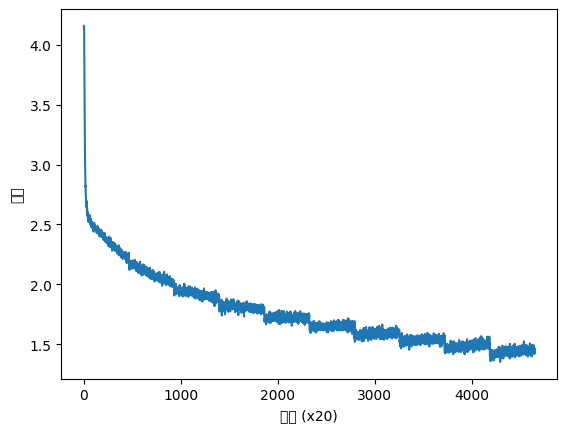

In [ ]:
# coding: utf-8
import sys
sys.path.append('/content/drive/MyDrive/deep-learning-from-scratch-2-master')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
# config.GPU = True
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW
from ch04.skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

+ 윈도우 크기를 5, 은닉층의 뉴런 수를 100개로 설정했다.
+ 보편적으로 윈도우 크기는 2~10개, 은닉층 뉴런 수는 50~500개 정도면 좋은 결과를 얻는다.

+ PTB는 말뭉치 크기가 커서 학습 시간이 오래 걸리기에 GPU를 사용할 수 있는 모드를 넣었다.
+ #config.GPU = True 주석을 해제하면 되고 GPU를 사용하려면 엔비디아 GPU를 장착한 컴퓨터여야 하고 쿠파이를 미리 설치해야 한다.

+ 학습이 끝나면 가중치를 꺼내 나중에 이용할 수 있는 파일에 보관하는데 이때 피클 기능을 이용한다.
+ 피클은 파이썬 코드의 객체를 파일로 저장하는데 이용할 수 있다.

### 4.3.3 CBOW 모델 평가

+ 앞 절에서 학습한 단어의 분산 표현을 평가해보자.
+ 2장에서 구현한 most_similar() 메서드를 이용하여 단어 몇 개에 대해 거리가 가장 가까운 단어들을 뽑아보자.

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/deep-learning-from-scratch-2-master')
from common.util import most_similar, analogy
import pickle

pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 i: 0.71875
 we: 0.71826171875
 your: 0.62646484375
 they: 0.58251953125
 reasonable: 0.55810546875

[query] year
 month: 0.83349609375
 week: 0.78369140625
 summer: 0.7548828125
 spring: 0.73095703125
 decade: 0.67822265625

[query] car
 luxury: 0.6435546875
 auto: 0.5947265625
 truck: 0.5771484375
 cars: 0.57666015625
 window: 0.55419921875

[query] toyota
 engines: 0.66943359375
 weyerhaeuser: 0.654296875
 seita: 0.638671875
 nissan: 0.6259765625
 supermarkets: 0.61376953125


+ 결과를 보면 you와 비슷한 단어로 i, we 등이 나왔다.
+ year와 비슷한 단어로는 month, week 같은 기간을 뜻하는 단어들이 나왔다.
+ toyota와 비슷한 단어로는 engines, weyerhaeuser 등 자동차와 관련된 단어들이 나왔다.
+ 이 결과를 보면 CBOW 모델로 획득된 단어의 분산 표현은 꽤 괜찮은 특성을 지닌다고 할 수 있다.

+ word2vec으로 얻은 단어의 분산 표현은 비슷한 단어를 가까이 모으고, 더 복잡한 패턴을 파악한다.
+ 예를들어 king - man + woman = queen 으로 유명한 유추 문제이다.
+ 즉 word2vec의 단어의 분산 표현을 사용하면 유추 문제를 벡터의 덧셈과 뺄셈으로 풀 수 있다.
+ 실제로 유추 문제를 풀 때 단어 벡터 공간에서 man $→$ woman 벡터와 king $\rightarrow ?$ 벡터가 가능한 한 가까워지는 단어를 찾는다.


<img src='http://drive.google.com/uc?export=view&id=1bvZsU34e2detbrH2GXf0saBrj1N5GRwC' width = 550/><br>

+ man의 분산 표현을 vec(man)이라 하면 얻고 싶은 관계를 수식으로 나타내면 vec(woman)-vec(man)=vec(?)-vec(king)이 된다.
+ vec(king)+vec(woman)-vec(man)=vec(?)라는 벡터에 가장가까운 단어 벡터를 구하는 문제가 된다.
+ 이 로직은 commom/util.py 의 analogy()에서 구현되어 있다.
+ 실제로 유추 문제를 몇 가지 풀어보자.

In [ ]:
# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

--------------------------------------------------

[analogy] king:man = queen:?
 a.m: 5.33984375
 woman: 5.1171875
 carolinas: 4.99609375
 father: 4.78125
 amendment: 4.66015625

[analogy] take:took = go:?
 eurodollars: 4.66015625
 're: 4.5234375
 were: 4.25
 went: 4.203125
 came: 4.12890625

[analogy] car:cars = child:?
 a.m: 7.515625
 rape: 5.8984375
 daffynition: 5.5625
 children: 5.296875
 incest: 5.109375

[analogy] good:better = bad:?
 rather: 5.57421875
 more: 5.47265625
 less: 5.3046875
 greater: 4.00390625
 faster: 3.904296875


+ 이렇게 word2vec으로 얻은 단어의 분산 표현을 사용하면 벡터의 덧셈과 뺄셈으로 유추 문제를 해결할 수 있다.

## 4.4 word2vec 남은 주제

### 4.4.1 word2vec을 사용한 애플리케이션의 예

+ 자연어 처리 분야에서 단어의 분산 표현이 중요한 이유는 전이 학습에 있다.
+ 전이 학습은 한 분야에서 배운 지식을 다른 분야에도 적용하는 기법이다.
+ 자연어 문제를 풀 때 단어의 분산 표현을 처음부터 학습하기 보다는 먼저 큰 말뭉치로 학습을 끝낸 후, 그 분산 표현을 이용한다.
+ 먼저 단어를 벡터로 변환하는데 이때 학습을 미리 끝낸 단어의 분산 표현을 이용할 수 있다.

+ 단어의 분산 표현은 단어와 문장을 고정 길이 벡터로 변환할 수 있다는 장점이 있다.
+ 문장을 고정 길이 벡터로 변환하는 방법은 문장의 각 단어를 분산 표현으로 변환하고 그 합을 구하는 것이다.
+ 이를 bag-of-words라 하여 단어의 순서를 고려하지 않은 모델이다.
+ 자연어를 벡터로 변환할 수 있다면 일반적인 머신러닝 기법을 적용할 수 있기 때문에  
단어나 문장을 고정 길이 벡터로 변환할 수 있다는 점을 매우 중요하다.

<img src='http://drive.google.com/uc?export=view&id=1oZMqIzr5vOsJW9F98tiYrOYQXKRdYcHh' width = 550/><br>

### 4.4.2 단어 벡터 평가 방법

+ word2vec을 통해 얻는 분산 표현이 좋은지 평가하는 방법을 살펴보자.
+ 단어의 분산 표현은 특정한 애플리케이션에서 사용되는 것이 대부분인데 궁극적으로 원하는 것은 정확도 높은 시스템이다.
+ 이때 시스템은 단어의 분산 표현을 만드는 시스템과 특정 문제에 대해 분류를 수행하는 시스템 등 여러 시스템으루 구성된다.

+ 단어의 분산 표현을 만드는 시스템과 분류하는 시스템의 학습은 따로 수행할 수 있다.
+ 이때 단어의 분산 표현의 차원 수가 최종 정확도의 어떤 영향을 주는지 조사하려면  
단어의 분산 표현을 학습하고 분산 표현을 사용하여 또 하나의 머신러닝 시스템을 학습시켜야 한다.
+ 즉 두 단계의 학습을 수행한 다음 평가해야 하므로 시간이 오래걸린다.

+ 따라서 단어의 분산 표현의 우수성을 실제 애플리케이션과 분리해 평가하는 것이 일반적이고  
이때 평가 착도가 단어의 유사성이나 유추 문제를 활용한 평가이다.
+ 단어의 유사성 평가에서는 사람이 작성한 단어 유사도를 검증 세트를 사용해 평가한다.
+ 유추 문제를 활용한 평가는 유추 문제를 출제하고 그 정답룰로 단어의 분산 표현의 우수성을 측정한다.

<img src='http://drive.google.com/uc?export=view&id=1RnVFPbeONgsUx8T-wjd0pzUavkIgnmMK' width = 550/><br>

__NOTE__ 위 결과로 부터 다음 사항을 알 수 있다.
+ 모델에 따라 정확도가 다르다.
+ 일반적으로 말뭉치가 클수록 결과가 좋다.
+ 단어 벡터 차원 수는 적당한 크기가 좋다.

+ 유추 문제를 이용하면 단어의 이미나 문법적인 문제를 제대로 이해하고 있는지를 측정할 수 있다.
+ 다만 유추 문제에 의한 평가가 높다고 해서 애플리케이션에서도 반드시 좋은 결과가 나오리라는 보장은 없다.

## 4.5 정리

+ Embedding 계층은 단어의 분산 표현을 담고 있으며, 순전파 시 지정한 단어 ID의 벡터를 추출한다.
+ word2vec은 어휘 수의 중가에 비례하여 계산량도 증가하므로, 근사치로 계산하는 빠른 기법을 사용하면 좋다.
+ 네거티브 샘플링은 부정적 예를 몇 개 샘플링하는 기법으로, 이를 이용하면 다중 분류를 이진 분류처럼 취급할 수 있다.
+ word2vec으로 얻은 단어의 분산 표현에는 단어의 의미가 녹아들어 있으며, 비슷한 맥락에서 사용되는 단어는 단어 벡터 공간에서 가까이 위치한다.
+ word2vec의 단어의 분산 표현을 이용하면 유추 문제를 벡터의 덧셈과 뺄셈으로 풀 수 있게 된다.
+ word2vec은 전이 학습 측면에서 특히 중요하며, 그 단어의 분산 표현은 다양한 자연어 처리 작업에 이용할 수 있다.